# Example notebook for Speckle Flow SIM - Simulation
This notebook contains a simulation reconstruction on a dynamic Shepp-Logan phantom. Full details can be found in our technical paper ["Dynamic Structured Illumination Microscopy with a Neural Space-time Model"](https://arxiv.org/pdf/2206.01397).

### Please cite this work as:
```
@article{cao2022dynamic,
  title={Dynamic Structured Illumination Microscopy with a Neural Space-time Model},
  author={Cao, Ruiming and Liu, Fanglin Linda and Yeh, Li-Hao and Waller, Laura},
  journal={arXiv preprint arXiv:2206.01397},
  year={2022}
}
```

![overview](img/overview.png)

# Import dependencies

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
# %matplotlib inline
import os
import functools
import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
import flax
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import calcil as cc

import speckle_flow
import spacetime
import utils

# System parameters
Define the parameters for the imaging system

In [2]:
# setup
pixel_size = 2.4
mag = 12.5
dx = pixel_size / mag
RI_medium = 1.0
dim_yx = (200,300)
padding_yx = (50, 50)
NA = 0.25
wavelength = 0.532
extent = [0, dim_yx[1] * dx, 0, dim_yx[0] * dx]
param = utils.SystemParameters(dim_yx, wavelength, NA, dx, RI_medium, padding_yx)

# Dynamic scene
Generate a temporal sequence of a moving phantom

In [3]:
num_frames = 40
timepoints = np.arange(num_frames) / num_frames

# define motion
list_xyrot = utils.generate_linear_motion(timepoints, start_pos_yx=(-3, 8), end_pos_yx=(3, -8), rot_start=0, rot_end=-80)
list_xyrotscale = np.concatenate((list_xyrot, np.ones((num_frames, 1)) * 0.6), 1)

# define object
phantom_obj = utils.PhantomTemporal(param)
phase_t = np.asarray([phantom_obj.generate_shepp_logan([xyrotscale], max_value=np.pi)[0] for xyrotscale in list_xyrotscale])
amplitude_t = np.asarray([phantom_obj.generate_shepp_logan([xyrotscale])[1] for xyrotscale in list_xyrotscale])

data_name = 'phantom_sim'

### Visualize the phantom

interactive(children=(IntSlider(value=0, description='i', max=39), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrames(i)>

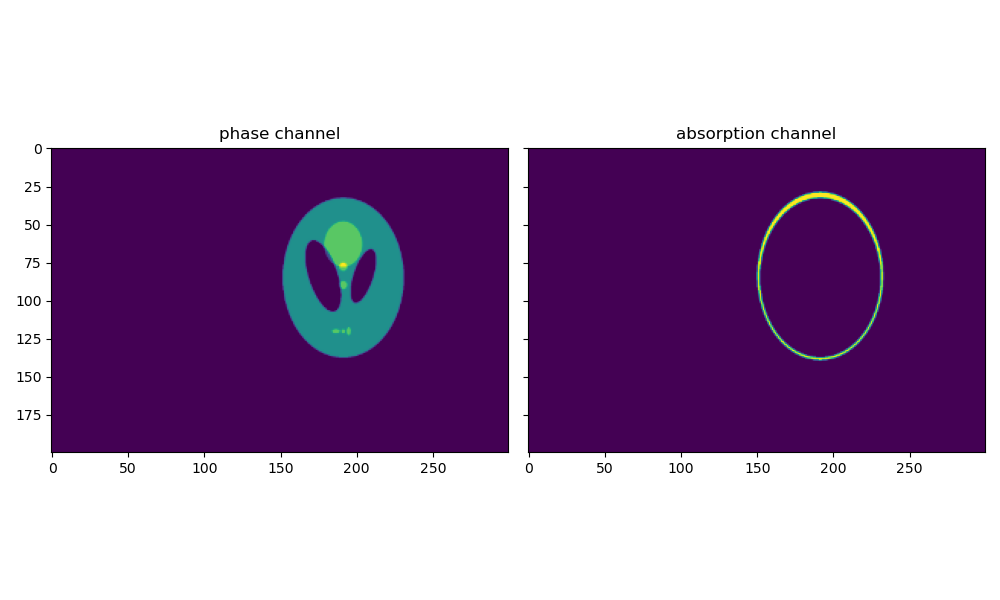

In [4]:
f, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
frames = []

def init():
    frames.append(axes[0].imshow(np.abs(phase_t[0])))
    frames.append(axes[1].imshow(amplitude_t[0]))
    axes[0].set_title('phase channel')
    axes[1].set_title('absorption channel')
    f.tight_layout()

init()
def updateFrames(i):
    frames[0].set_data(np.abs(phase_t[i]))
    frames[1].set_data(amplitude_t[i])

interact(updateFrames, i=IntSlider(min=0, max=len(phase_t)-1, step=1, value=0))

# (a) forward model
Run the forward model to simulate/render the measured intensity images from Speckle Flow SIM system.

In [5]:
param_speckle = utils.SystemParameters((dim_yx[0]+padding_yx[0]*2, dim_yx[1]+padding_yx[1]*2), wavelength, NA, dx, RI_medium, padding_yx)
U_speckle = utils.generate_speckle(param_speckle, speckle_size_coef=0.15, strength_coef=1.0, band_limited=True, padding=True, prop_distance=10.0, seed=2385)

forward_obj = speckle_flow.SpeckleSIMCoherent(param)
variables_forward = {'params': {'pupil_phase_aberration': jnp.zeros((param.dim_yx[0]+2*param.padding_yx[0], param.dim_yx[1]+2*param.padding_yx[1])),
                                'pupil_amp_aberration': jnp.ones((param.dim_yx[0]+2*param.padding_yx[0], param.dim_yx[1]+2*param.padding_yx[1]))}}
I_forward = forward_obj.apply(variables_forward, U_speckle, jnp.asarray(phase_t), jnp.asarray(amplitude_t))

### Visualize intensity images

interactive(children=(IntSlider(value=0, description='t', max=39), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrames_forward_viz(t)>

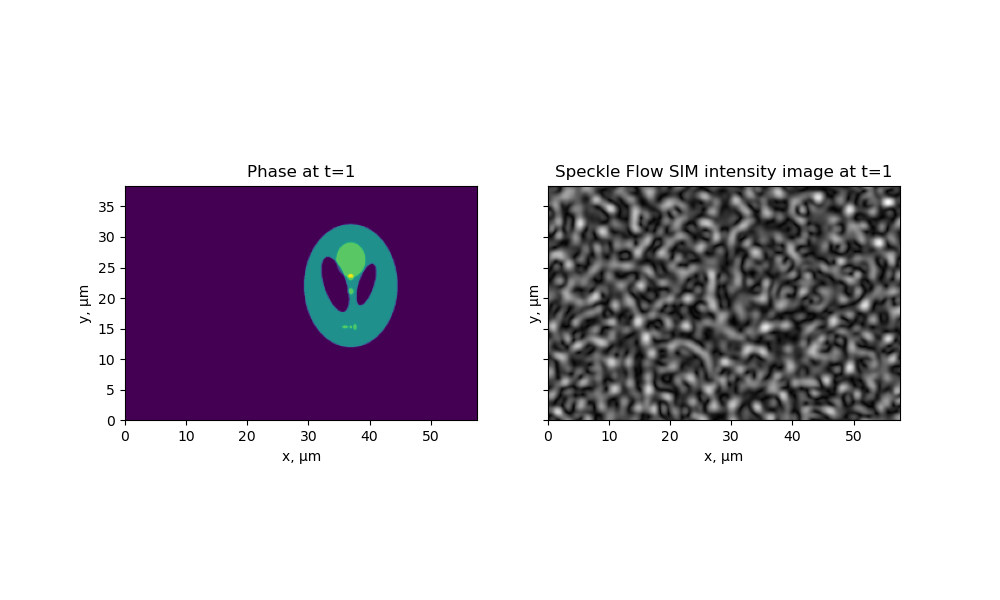

In [6]:
f_forward_viz, axes_forward_viz = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
frames_forward_viz = []

def init_forward_viz():
    frames_forward_viz.append(axes_forward_viz[0].imshow(np.abs(phase_t[0]), extent=extent))
    frames_forward_viz.append(axes_forward_viz[1].imshow(I_forward[0], cmap='gray', extent=extent))
    axes_forward_viz[0].set_xlabel('x, µm')
    axes_forward_viz[0].set_ylabel('y, µm')
    axes_forward_viz[1].set_xlabel('x, µm')
    axes_forward_viz[1].set_ylabel('y, µm')

init_forward_viz()
def updateFrames_forward_viz(t):
    frames_forward_viz[0].set_data(np.abs(phase_t[t]))
    frames_forward_viz[1].set_data(I_forward[t])
    axes_forward_viz[0].set_title(f'Phase at t={t+1}')
    axes_forward_viz[1].set_title(f'Speckle Flow SIM intensity image at t={t+1}')

interact(updateFrames_forward_viz, t=IntSlider(min=0, max=len(I_forward)-1, step=1, value=0))

# (b) reconstruction via a neural space-time model
Define a neural space-time model and use it to recover the dynamic scene encoded in the raw intensity images.

### Neural space-time model definition

In [7]:
mlp_param = spacetime.MLPParameters(net_depth=8, net_width=64, net_activation=nn.celu, skip_layer=4)
motion_mlp_param = spacetime.MLPParameters(net_depth=4, net_width=32, net_activation=nn.relu,
                                           skip_layer=4, kernel_init=nn.initializers.normal(5e-2))
space_time_param = spacetime.SpaceTimeParameters(mlp_out_activation=nn.celu,
                                                 posenc_min=0, posenc_max=6,
                                                 time_posenc_min=0, time_posenc_max=4,
                                                 n_step_coarse_to_fine=5000,
                                                 include_padding=False)

speckle_flow_param = speckle_flow.SpeckleFlowSIMParameters(space_time_param=space_time_param,
                                                          motion_mlp_param=motion_mlp_param, mlp_param=mlp_param)

### Loss definition

In [8]:
def loss_l2(forward_output, variables, input_dict, intermediates):
    loss_l2 = ((input_dict['img'] - forward_output[0]) ** 2).mean()
    return loss_l2

loss_fn = cc.loss.Loss(loss_l2, 'l2')

### Initialization of the data loader and the neural space-time model

In [9]:
# load images
batch_size = 10
data_loader = cc.data_utils.loader_from_numpy({'img': I_forward, 't': timepoints}, prefix_dim=(batch_size,), seed=85472, )
sample_input_dict = next(data_loader)[0]

# initialize model
model = speckle_flow.SpeckleFlowSIMCoherent(param, speckle_flow_param)
rng = jax.random.PRNGKey(0)
variables = model.init(rng, input_dict=sample_input_dict)

variables = variables.unfreeze()
variables['params']['speckle_amp'] = jnp.asarray(np.abs(U_speckle))
variables['params']['speckle_phase'] = jnp.asarray(np.angle(U_speckle))
variables = flax.core.FrozenDict(variables)

# output function
def output_fn(variables_, train_state):
    phase_out =  np.array([model.apply(variables_, jnp.array([timepoints[t]]), train_state.step, 
                           method=lambda module, a, s: module.spacetime(a, s)[0,..., 0]) for t in jnp.arange(0, num_frames, num_frames-1)])
    abs_out = np.array([model.apply(variables_, jnp.array([timepoints[t]]), train_state.step,
                        method=lambda module, a, s: module.spacetime(a, s)[0,..., 1]) for t in jnp.arange(0, num_frames, num_frames-1)])
    
    return {'phase': phase_out, 'abs': abs_out}

### Run reconstruction

In [ ]:
%%time
recon_param = cc.reconstruction.ReconIterParameters(save_dir='./checkpoint/{}/'.format(data_name), n_epoch=20000)
no_update_params = cc.reconstruction.ReconVarParameters(lr=0)
spacetime_mlp_params = cc.reconstruction.ReconVarParameters(lr=5e-4, opt='adam', schedule='exponential',
                                                         schedule_kwargs={'transition_steps':20000, 'decay_rate': 0.2})
    
var_params = {'params': {'spacetime': spacetime_mlp_params, 'speckle_amp': no_update_params, 'speckle_phase': no_update_params,
                         'forward': no_update_params}}

recon_variables, recon = cc.reconstruction.reconstruct_multivars_sgd(model.apply, variables, var_params, data_loader, loss_fn, recon_param, output_fn)

recon_t = np.array([model.apply(recon_variables, jnp.array([timepoints[t]]), 
                       method=lambda module, a: module.spacetime(a)[0,..., ]) for t in jnp.arange(num_frames)])

### Visualization - through optimization epochs

In [70]:
f, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)
frames = []

def init():
    frames.append(axes[0].imshow(np.abs(phase_t[0]), clim=(0,np.pi), extent=extent))
    frames.append(axes[1].imshow(np.abs(recon['phase'][0][0]), clim=(0,np.pi), extent=extent))
    axes[0].set_xlabel('x, µm')
    axes[0].set_ylabel('y, µm')
    axes[1].set_xlabel('x, µm')
    axes[1].set_ylabel('y, µm')
    f.colorbar(frames[0], ax=axes.ravel().tolist())

init()
def updateFrames(i):
    frames[0].set_data(np.abs(phase_t[0]))
    frames[1].set_data(np.abs(recon['phase'][i][0]))
    axes[0].set_title(f'ground truth phase')
    axes[1].set_title(f'recon. phase at epoch={(i+1)*recon_param.output_every}')

interact(updateFrames, i=IntSlider(min=0, max=len(recon['phase'])-1, step=1, value=0))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=0, description='i', max=19), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrames(i)>

### Visualization - through timepoints

In [69]:
f, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)
frames = []

def init():
    frames.append(axes[0].imshow(np.abs(phase_t[0]), clim=(0,np.pi), extent=extent))
    frames.append(axes[1].imshow(np.abs(recon['phase'][0][0]), clim=(0,np.pi), extent=extent))
    axes[0].set_xlabel('x, µm')
    axes[0].set_ylabel('y, µm')
    axes[1].set_xlabel('x, µm')
    axes[1].set_ylabel('y, µm')
    f.colorbar(frames[0], ax=axes.ravel().tolist())

init()
def updateFrames(t):
    frames[0].set_data(np.abs(phase_t[t]))
    frames[1].set_data(np.abs(recon_t[t][:, :, 0]))
    axes[0].set_title(f'ground truth at t={t+1}')
    axes[1].set_title(f'recon. at t={t+1}')

interact(updateFrames, t=IntSlider(min=0, max=recon_t.shape[0]-1, step=1, value=0))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=0, description='t', max=39), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrames(t)>